In [1]:
"""
Otus, курс Data Scientist, старт дек.2018
Задание к уроку N1

Задача: Анализируем сообщения из vk.com

План работ.

Этап 1 - отображен в этом блокноте.
Выгружаем некоторое кол-во сообщений, сохраняем, преобразуем в csv-формат, проводим exploratory-анализ - какие данные есть,
что в них может быть интересного.
Задача на этап 1: придумать вопрос, на который будем искать ответ.

Этап 2 - отображен в python-проекте gathering.
Выгружаем данные, в минимально необходимом количестве, преобразуем в формат, удобный для анализа.
Проводим анализ с целью получить ответ на вопрос.
Задача на этап 2: на поставленный вопрос
либо получить ответ с некоторой достоверностью,
либо показать, что этих данных недостаточно для получения ответа.
"""

In [1]:
import vk_api
import io
import json, codecs
import time

In [2]:
"""
Загружаем данные из vk_api, сохраняем на диск
"""

'\nЗагружаем данные из vk_api, сохраняем на диск\n'

In [150]:
# credentials: нужно указать логин/пароль к vk.com
# чтобы случайно не закомитить версию с логин/пароль - выносим эти данные в отдельный файл, который исключаем в .gitignore
credentialsFileName = "vk_login_password.txt" # формат файла: 1-я строка = логин, 2-я строка = пароль
# затираем значения, которые могли сохраниться с прошлых запусков (в notebook)
login = '+71231234567' 
password = ''

# загружаем значения из файла
try:
    loginFile = open(credentialsFileName, 'r')
    login = loginFile.readline().strip() # в формате: '+71231234567'
    password = loginFile.readline().strip()
except IOError:
    print ("No file with login/password: создайте файл " + credentialsFileName + ", в котором 1-я строка = логин, 2-я строка = пароль")

In [151]:
# используем:
#  wrapper-lib vk_api: https://github.com/python273/vk_api
#  описание Api от vk: https://vk.com/dev/groups.search?params[q]=bitcoin&params[future]=0&params[market]=0&params[offset]=3&params[count]=3&params[v]=5.92

In [2]:
# параметры запуска
GROUP_KEYWORD = 'bitcoin' # интересуют сообщества, в названии которых есть такое слово
COUNT_GROUPS = 50 # обработаем столько сообществ
COUNT_MESSAGES_PER_GROUP = 100 # в каждом сообществе, со стены возьмем столько сообщений

In [153]:
# получаем соединение, api
vk_session = vk_api.VkApi(login, password)
vk_session.auth(token_only=True)
api = vk_session.get_api()

In [3]:
# константы и правила, которые используем при работе с файлами
FOLDER_PREFIX = './files/' # folder, в которую складываем файлы
FILE_EXTENSION = '.txt' # расширение для json-файлов

def fileNameFunc(rawFileName):
    return FOLDER_PREFIX + rawFileName + FILE_EXTENSION

In [155]:
# Данные по сообществам - получаем по http
def obtainGroups(api, keyword, count):
    print("obtainGroups, keyword=" + keyword + ", count=" + str(count))
    results = api.groups.search(q=keyword, count=count)
    return results['items']

In [156]:
# получить N записей со стены сообщества/пользователя
def obtainWallItems(api, owner_id, count):
    # protection: проверяем входные значения
    if(count > 100): # todo: можно приделать scroll, то есть, разбить запрос на несколько, в каждом count не более 100
        raise AssertionError("count должен быть <= 100, но передали:" + str(count))

    # основная часть
    results = api.wall.get(owner_id=owner_id, filter = 'owner', count = count, offset=0)
    print("obtainWallItems, owner_id=" + str(owner_id) + ", retrieve " + str(len(results['items'])) + ", of total " + str(results['count']))
    return results['items']

# для напоминания - сохраним в комментариях альтернативный метод vk_api для получения сообщений со стены сообщества
#tools = vk_api.VkTools(vk_session)
#wall = tools.get_all('wall.get', 10, {'owner_id': -92718200, 'filter':'owner'})

In [157]:
# записываем json в файл
def writeJsonToFile(fileName, jsonData):
    with io.open(fileName, 'w', encoding='utf-8') as f:
        f.write(json.dumps(jsonData, ensure_ascii=False, sort_keys=True, indent=4))

In [158]:
# получаем все интересующие сообщества, записываем в файл
groups = obtainGroups(api, 'bitcoin', COUNT_GROUPS)
writeJsonToFile(fileNameFunc('groups'), groups)

obtainGroups, keyword=bitcoin, count=50


In [159]:
# отфильтруем сообщества - нам нужны только те, у которых есть доступ к сообщениям на стене
group_ids = []
for group in groups:
    if(group['is_closed'] == 0):
        group_ids.append(group['id'])
    else:
        print('skip group:' + str(group['id']))
print('total groups для обработки: ' + str(len(group_ids)))

skip group:16269693
skip group:16219861
total groups для обработки: 48


In [160]:
# для каждого сообщества - получаем сообщения со стены и записваем в соотв.файл
counter = 1 # счетчик, используем в названии файлов
for group_id in group_ids:
    vk_id = -1 * group_id # vk_api.wall.get по наличию знака минус - определяет, что требуется именно сообщество
    items = obtainWallItems(api=api, owner_id=vk_id, count=COUNT_MESSAGES_PER_GROUP)
    rawFileName = str(counter) + "_" + str(group_id)
    writeJsonToFile(fileNameFunc(rawFileName), items)
    counter = counter + 1
    time.sleep(0.5) # соблюдаем этикет

obtainWallItems, owner_id=-46371384retrieve 100, of total 48228
obtainWallItems, owner_id=-92718200retrieve 100, of total 10601
obtainWallItems, owner_id=-632045retrieve 100, of total 28475
obtainWallItems, owner_id=-93604475retrieve 100, of total 14366
obtainWallItems, owner_id=-59454515retrieve 100, of total 31644
obtainWallItems, owner_id=-79363873retrieve 100, of total 830
obtainWallItems, owner_id=-51789870retrieve 100, of total 13932
obtainWallItems, owner_id=-92357206retrieve 100, of total 132
obtainWallItems, owner_id=-101271420retrieve 100, of total 5135
obtainWallItems, owner_id=-29387592retrieve 100, of total 1750
obtainWallItems, owner_id=-158943684retrieve 100, of total 149
obtainWallItems, owner_id=-122422421retrieve 100, of total 6558
obtainWallItems, owner_id=-74106120retrieve 1, of total 1
obtainWallItems, owner_id=-50725681retrieve 100, of total 1397
obtainWallItems, owner_id=-140465118retrieve 33, of total 33
obtainWallItems, owner_id=-50061159retrieve 59, of total 5

In [ ]:
"""
Анализируем сохраненные данные
"""

In [ ]:
# пройти по всем файлам, которые с названием [N]_[id].txt
# 1. Определяем набор полей, которые интересуют
#   1.1 собираем набор существующих полей -> просматриваем, выбираем те, которые интересуют
#   1.2 по выбранным полям - составляем статистику, уточняем, что именно будем выгружать
# 2. Составляем csv-файл со всеми сообщениями, сохраняем

In [4]:
from os import listdir
from os.path import isfile, join
import re
import csv

In [5]:
# функции и константы

RESULTS_FILE_NAME = 'result.csv'
SCRAPPED_DATA_FILE_REGEXP = re.compile(r'^([\d]+)_([\d]+).*$')

# проанализировать массив json - какие поля встречаются
def fieldsIn(fileContent):
    result = []
    for message in fileContent:
        for key, value in message.items():
            if(key not in result):
                result.append(key)
    return result

# объединяем списки, оставляем уникальные элементы
def clueFiledsFunc(acc, addFields):
    for field in addFields:
        if(field not in acc):
            acc.append(field)
    return acc

# определяем, какие поля встречаются в загруженных данных
def revealFieldNames(fileNameList):
    fields = []
    for fileName in scrapped_data_files:
        with io.open(join(FOLDER_PREFIX, fileName), 'r', encoding='utf-8') as f:
            fileContent = json.load(f)
            fields = clueFiledsFunc(fields, fieldsIn(fileContent))
    return fields

In [34]:
# названия файлов со scrapped данными
scrapped_all_files = [f for f in listdir(FOLDER_PREFIX) if isfile(join(FOLDER_PREFIX, f))]
# только те файлы, которые про сообщения на стене сообщества
scrapped_data_files = []
regexp = SCRAPPED_DATA_FILE_REGEXP
for fileName in scrapped_all_files:
    if(regexp.search(fileName)): 
        scrapped_data_files.append(fileName)

In [35]:
fields = revealFieldNames(scrapped_data_files)
print(fields)

['attachments', 'comments', 'date', 'from_id', 'id', 'is_favorite', 'likes', 'marked_as_ads', 'owner_id', 'post_source', 'post_type', 'reposts', 'text', 'views', 'is_pinned', 'signer_id', 'copy_history']


In [6]:
# поля, которые интересуют
actual_fields = {
    'comments_count': 'comments.count',
    'date':'date',
    #'is_favorite':'is_favorite', # df['is_favorite'].value_counts() - найдено, что всегда 1 значение
    #'is_pinned':'is_pinned', # df['is_pinned'].value_counts() - найдено, что всегда 1 значение
    #'likes_can_like':'likes.can_like', # df['likes_can_like'].value_counts() - найдено, что всегда 1 значение
    #'likes_can_publish':'likes.can_publish', # df['likes_can_publish'].value_counts() - найдено, что всегда 1 значение
    'likes_count':'likes.count',
    'marked_as_ads':'marked_as_ads',
    'post_source':'post_source.type',
    #'post_type':'post_type', # df['post_type'].value_counts() - найдено, что всегда 1 значение
    'reposts_count':'reposts.count',
    'text':'text',
    'views_count':'views.count'
}
# в обработанном виде
csv_fields = []
json_fields = []
for key, value in actual_fields.items():
    csv_fields.append(key)
    json_fields.append(value)

In [43]:
# получаем значение поля в json
def revealFieldValue(jsonData,fieldPath):
    none_value = ''
    path = fieldPath.split('.')
    data = jsonData
    for step in path[:-1]:
        if step in data:
            data = data[step]
        else:
            return none_value
    data = data.get(path[-1], none_value)
    #print(data)
    return data

In [44]:
# из объекта - получаем строку для csv
def produceLine(jsonData, fieldsList):
    result = []
    for field in fieldsList:
        data = revealFieldValue(jsonData, field)
        result.append(data)
    return result

# из файла со scrapped_data получаем строки для csv
def produceCsvRowsForFile(fileName, fieldsList):
    group_id = SCRAPPED_DATA_FILE_REGEXP.match(fileName).group(2)
    result = []
    with io.open(join(FOLDER_PREFIX, fileName), 'r', encoding='utf-8') as f:
        fileContent = json.load(f)
        for doc in fileContent:
            row = [group_id] + produceLine(doc, fieldsList)
            #row.append(group_id)
            result.append(row)
    return result
            
# для всех перечисленных файлов - записываем получаемые строки в csv (в памяти держим строки только для одного файла)
def writeCsvLinesByFiles(csvWriter, fileNameList, fieldsList):
    for fileName in fileNameList:
        print('fileName: ' + fileName)
        rows = produceCsvRowsForFile(fileName, fieldsList)
        #print("***")
        #print(rows[1])
        for row in rows:            
            csvWriter.writerow(row)
            

        

In [45]:
with open(RESULTS_FILE_NAME, 'w', newline='', encoding='utf-8') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter=',')
    csvWriter.writerow(['group_id'] + csv_fields) # 1-я строка - это названия столбцов
    print(json_fields)
    writeCsvLinesByFiles(csvWriter, scrapped_data_files, json_fields)

['comments.count', 'date', 'likes.count', 'marked_as_ads', 'post_source.type', 'reposts.count', 'text', 'views.count']
fileName: 10_29387592.txt
fileName: 11_158943684.txt
fileName: 12_122422421.txt
fileName: 13_74106120.txt
fileName: 14_50725681.txt
fileName: 15_140465118.txt
fileName: 16_50061159.txt
fileName: 17_50774319.txt
fileName: 18_147911279.txt
fileName: 19_62032126.txt
fileName: 1_46371384.txt
fileName: 20_30451584.txt
fileName: 21_63589724.txt
fileName: 22_19354230.txt
fileName: 23_65314134.txt
fileName: 24_33135732.txt
fileName: 25_79858655.txt
fileName: 26_70023397.txt
fileName: 27_43011371.txt
fileName: 28_113755164.txt
fileName: 29_66153827.txt
fileName: 2_92718200.txt
fileName: 30_55500226.txt
fileName: 31_61469977.txt
fileName: 32_150541976.txt
fileName: 33_53986544.txt
fileName: 34_152549864.txt
fileName: 35_83377401.txt
fileName: 36_144516691.txt
fileName: 37_59683167.txt
fileName: 38_112446933.txt
fileName: 39_154469944.txt
fileName: 3_632045.txt
fileName: 40_16275

In [ ]:
"""
Анализируем полученные данные, чтобы выделить, какие столбцы важные
"""

In [7]:
import pandas as pd
import numpy as np
import matplotlib
from datetime import datetime
from datetime import date

In [8]:
df = pd.read_csv(RESULTS_FILE_NAME)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count
0,29387592,1,1549998127,1,0,vk,0,Состоялся долгожданный релиз мобильного прилож...,893.0
1,29387592,0,1549997035,4,0,vk,0,Исследовательская компания Diar опубликовала н...,1186.0
2,29387592,3,1549896060,4,0,vk,0,"Торговая P2P-платформа Localbitcoins заявила, ...",2285.0
3,29387592,9,1549634023,7,0,vk,0,Тогда курс первой криптовалюты достигал отметк...,2328.0
4,29387592,0,1549454503,6,0,vk,3,Исследователи канадской финансовой компании Ca...,2727.0


In [9]:
# для удобства - создадим столбец, который представляет дату в виде "номер дня начиная от date0"
date_start = datetime(2018, 12, 1)
df['day_number'] = df['date'].apply(lambda x: (datetime.fromtimestamp(int(x)) - date_start).days)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count,day_number
0,29387592,1,1549998127,1,0,vk,0,Состоялся долгожданный релиз мобильного прилож...,893.0,73
1,29387592,0,1549997035,4,0,vk,0,Исследовательская компания Diar опубликовала н...,1186.0,73
2,29387592,3,1549896060,4,0,vk,0,"Торговая P2P-платформа Localbitcoins заявила, ...",2285.0,72
3,29387592,9,1549634023,7,0,vk,0,Тогда курс первой криптовалюты достигал отметк...,2328.0,69
4,29387592,0,1549454503,6,0,vk,3,Исследователи канадской финансовой компании Ca...,2727.0,67


In [88]:
from datetime import datetime
from datetime import date
date0 = datetime(2018, 12, 1)
date2 = datetime.fromtimestamp(1549998127) #.strftime('%Y-%m-%d %H:%M:%S')
delta = date2 - date0
print('date0: ' + date0.strftime('%Y-%m-%d %H:%M:%S'))
print('date2: ' + date2.strftime('%Y-%m-%d %H:%M:%S'))
print(delta.days)

date0: 2018-12-01 00:00:00
date2: 2019-02-12 22:02:07
73


In [10]:
df.describe()

,group_id,comments_count,date,likes_count,marked_as_ads,reposts_count,views_count,day_number
count,3.781000e+03,3781.000000,3.781000e+03,3781.000000,3781.000000,3781.000000,3.460000e+03,3781.000000
mean,7.638030e+07,10.995504,1.528260e+09,26.953716,0.008992,4.040994,2.692551e+03,-178.310235
std,4.265118e+07,182.217344,3.515309e+07,559.547431,0.094413,85.954062,5.273675e+04,406.841189
min,6.320450e+05,0.000000,1.398186e+09,0.000000,0.000000,0.000000,3.000000e+00,-1684.000000
25%,5.072568e+07,0.000000,1.526733e+09,1.000000,0.000000,0.000000,1.680000e+02,-196.000000
50%,6.531413e+07,0.000000,1.539411e+09,3.000000,0.000000,0.000000,4.850000e+02,-49.000000
75%,1.012714e+08,1.000000,1.547749e+09,8.000000,0.000000,2.000000,1.451000e+03,47.000000
max,1.627583e+08,8687.000000,1.550067e+09,32506.000000,1.000000,5182.000000,2.567530e+06,74.000000


In [14]:
# Для каждого столбца выполним такой код - проверим, что есть разнообразие в значениях
print(df['post_source'].value_counts())

vk     2972
api     659
rss     100
mvk      50
Name: post_source, dtype: int64


In [18]:
# столбец 'marked_as_ads' проанализируем чуть подробней - в 1% строк значение отличается 
# -> если это происходит для одного group_id - тогда данные интереса не представляют (корелляция с group_id).
tmp_df = df[df['marked_as_ads'] == 1]
print(tmp_df['group_id'].value_counts())
# решение = оставляем столбец

92718200     12
33135732      7
632045        6
93604475      3
46371384      2
19354230      1
51789870      1
79363873      1
122422421     1
Name: group_id, dtype: int64


In [12]:
df.hist()

C:\installed\anaconda\envs\py36\lib\site-packages\numpy\lib\histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D3DB384588>,
      dtype=object)

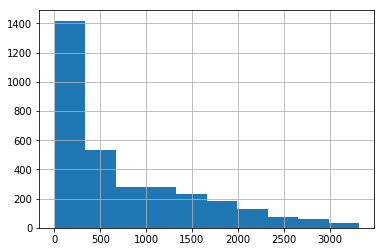

In [74]:
df['views_count'].hist()

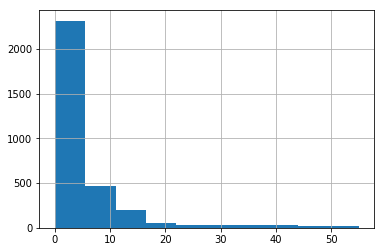

In [76]:
df['likes_count'].hist()

In [70]:
df["views_count"].quantile(0.95)

3812.399999999999

In [75]:
columnName = 'likes_count'
barrier = df[columnName].quantile(0.99)
df = df[df[columnName] < barrier]

In [77]:
df.groupby('post_source').agg('mean')

,group_id,comments_count,date,likes_count,marked_as_ads,reposts_count,views_count
post_source,,,,,,,
api,8.435058e+07,1.090150,1.536768e+09,3.013356,0.000000,0.332220,533.579299
mvk,6.617306e+07,2.260000,1.544122e+09,5.180000,0.000000,1.180000,555.920000
rss,5.083492e+07,0.000000,1.549812e+09,0.000000,0.000000,0.010000,25.070000
vk,7.798098e+07,1.198113,1.539004e+09,5.800246,0.012305,1.067268,831.197703


In [109]:
counts_df = pd.DataFrame(df.groupby('day_number').size().reset_index(name='counts'))
grouped_df = df.groupby('day_number').agg(['mean'])
result_df = pd.merge(grouped_df, counts_df, on='day_number', how='outer')
result_df.head()

C:\installed\anaconda\envs\py36\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,day_number,"(group_id, mean)","(comments_count, mean)","(date, mean)","(likes_count, mean)","(marked_as_ads, mean)","(reposts_count, mean)","(views_count, mean)",counts
0,-663,21178038.0,0.0,1.486409e+09,18.0,0.0,0.0,1308.0,1
1,-637,21178038.0,0.0,1.488617e+09,18.0,0.0,3.0,1217.0,1
2,-635,21178038.0,0.0,1.488806e+09,13.0,0.0,0.0,1219.0,1
3,-621,21178038.0,0.0,1.490007e+09,46.0,0.0,0.0,1392.0,1
4,-571,21178038.0,0.0,1.494311e+09,12.0,0.0,0.0,1350.0,1


In [111]:
result_df.describe()

,day_number,"(group_id, mean)","(comments_count, mean)","(date, mean)","(likes_count, mean)","(marked_as_ads, mean)","(reposts_count, mean)","(views_count, mean)",counts
count,406.000000,4.060000e+02,406.000000,4.060000e+02,406.000000,406.000000,406.000000,406.000000,406.000000
mean,-142.278325,8.086678e+07,1.807553,1.531375e+09,6.085428,0.003628,0.978319,762.435137,7.849754
std,143.964549,2.741284e+07,3.569524,1.243922e+07,6.325387,0.020562,1.505076,581.310362,10.850708
min,-663.000000,1.935423e+07,0.000000,1.486409e+09,0.000000,0.000000,0.000000,39.000000,1.000000
25%,-237.500000,6.296759e+07,0.000000,1.523142e+09,2.333333,0.000000,0.125000,367.687500,3.000000
50%,-129.500000,8.054909e+07,0.594118,1.532482e+09,4.366667,0.000000,0.500000,657.452381,5.000000
75%,-27.250000,9.943744e+07,1.854396,1.541312e+09,7.750000,0.000000,1.200000,965.100000,9.000000
max,74.000000,1.525499e+08,41.800000,1.550047e+09,49.000000,0.250000,15.500000,3322.000000,104.000000


In [ ]:
"""
Вывод:
Для анализа интересны столбцы:
    'comments_count' - кол-во комментариев,
    'date' - дата публикации,
    'likes_count' - кол-во отметок "нравится",
    'marked_as_ads' - флаг "реклама",
    'post_source' - источник публикации,
    'reposts_count' - кол-во репостов,
    'views_count' - кол-во просмотров.
И еще один столбец:
    'text' - заглавие (в анализе не участвует, но для наглядности данных - оставляем).

Итого: 7 столбцов, и строк > 1000.
Данные удовлетворяют условию сдачи задания.
"""

In [ ]:
"""
По этим столбцам - можно предположить, что столбцы:
views_count, comments_count, reposts_count, likes_count
отражают интерес посетителей к публикации и вовлеченность в некоторый процесс, который публикация запускает.
Возможно, активность пользователей - различается для разных сообществ?

Вопрос N1:
Существует ли попарная корелляция между значениями в столбцах: views_count, comments_count, reposts_count, likes_count ?

Вопрос N2:
Существует ли корелляция между comments_count, reposts_count, likes_count?
То есть, возможно ли снизить размерность, если введем свойство "интерес к публикации" вместо этих 3-х столбцов?
Возможно, стоит добавить отношение к кол-ву просмотров? Пусть это будет второй вариант оценки "интерес к публикации".

Вопрос N3:
В каких сообществах сообщения вызывают наибольший интерес?
"""